## Imports

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from numpy import genfromtxt

# Data Split and Cross Validation
from sklearn.model_selection import train_test_split,cross_val_score


# ML Models
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Evaluation Metrics and Model Selection
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
import shap

# Utility Functions
from itertools import product
import random
from utils import *

c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = genfromtxt("data/data_np.csv", delimiter=',')
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'HOMA_IR',
       'BloodPressure_Category', 'Glucose_BMI_Interact',
       'Age_Insulin_Interact', 'Age_BMI_Interact', 'Age_Pregnancies_Interact',
       'Insulin_skin_Interact', 'Family_History', 'SkinThickness_to_BMI_Ratio',
       'Age_Group']

X = df[:, :18]
y = df[:, 18]

data = pd.DataFrame(X,columns=columns)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HOMA_IR,BloodPressure_Category,Glucose_BMI_Interact,Age_Insulin_Interact,Age_BMI_Interact,Age_Pregnancies_Interact,Insulin_skin_Interact,Family_History,SkinThickness_to_BMI_Ratio,Age_Group
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,0.000000,2.0,4972.8,0.0,1680.0,300.0,0.0,0.0,1176.0,2.0
1,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,0.000000,2.0,4263.9,0.0,745.6,256.0,0.0,0.0,0.0,1.0
2,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,20.656790,0.0,2500.9,1974.0,590.1,21.0,2162.0,0.0,646.3,1.0
3,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,16.948148,0.0,2418.0,2288.0,806.0,78.0,2816.0,0.0,992.0,1.0
4,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,264.125926,2.0,6008.5,28779.0,1616.5,106.0,24435.0,0.0,1372.5,2.0


## Data Split



**Improved Generalization through Separate Normalisation**


Normalising the training and validation data separately can improve model generalization in a few ways:

1. **Prevents Data Leakage**: Separately normalising training and validation data prevents information leakage from the validation set into the training process, reducing the risk of overfitting.

2. **Reflects Real-World Variation**: By adapting to the specific characteristics of each dataset, separate normalisation better prepares the model for unseen data with potentially different distributions.

3. **Enhanced Stability**: Separate normalisation ensures that each dataset is scaled appropriately, leading to a more stable training process and better convergence.



In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

### Z-score Normalization

This technique scales the values of a feature to have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean of the feature from each value, and then dividing by the standard deviation.

In [4]:
# Calculate means and standard deviations for the training set
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

X_test_mean = np.mean(X_test, axis=0)
X_test_std = np.std(X_test, axis=0)

X_val_mean = np.mean(X_val, axis=0)
X_val_std = np.std(X_val, axis=0)

# Z-score Normalization of train, validation, and test sets
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_val_mean) / X_val_std
X_test = (X_test - X_test_mean) / X_test_std

## Model Implementation

In [5]:
num_folds = 5



y_train = y_train.ravel()

## LogisticRegression
LogisticR = LogisticRegression(random_state=42, max_iter=10000)
LogisticR_cv = cross_val_score(LogisticR, X_train, y_train, cv=num_folds)
LogisticR.fit(X_train, y_train)
LogisticR_test_acc = LogisticR.score(X_test, y_test)

## Support Vector Machine (SVM)
clf = svm.SVC(random_state=0)
svm_cv = cross_val_score(clf, X_train, y_train, cv=num_folds)
clf.fit(X_train, y_train)
svm_test_acc = clf.score(X_test, y_test)

## K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn_cv = cross_val_score(knn, X_train, y_train, cv=num_folds)
knn.fit(X_train, y_train)
knn_test_acc = knn.score(X_test, y_test)

## RandomForestClassifier
RandomFC = RandomForestClassifier(random_state=42)
RandomFC_cv = cross_val_score(RandomFC, X_train, y_train, cv=num_folds)
RandomFC.fit(X_train, y_train)
RandomFC_test_acc = RandomFC.score(X_test, y_test)

# Find the best model based on cross-validation scores
best_model = max([(LogisticR_cv.mean(), "LogisticRegression"),
                  (svm_cv.mean(), "SVM"),
                  (knn_cv.mean(), "KNN"),
                  (RandomFC_cv.mean(), "RandomFC")])

print(f"Best model based on cross-validation: {best_model[1]}")
print(f"Cross-validation accuracy: {best_model[0]}")

# Test the best model on the test set
if best_model[1] == "LogisticRegression":
    print(f"Test accuracy with LogisticRegression: {LogisticR_test_acc}")
elif best_model[1] == "SVM":
    print(f"Test accuracy with SVM: {svm_test_acc}")
elif best_model[1] == "KNN":
    print(f"Test accuracy with KNN: {knn_test_acc}")
elif best_model[1] == "RandomFC":
    print(f"Test accuracy with RandomFC: {RandomFC_test_acc}")


Best model based on cross-validation: RandomFC
Cross-validation accuracy: 0.8933196064973691
Test accuracy with RandomFC: 0.9285714285714286


### SHAP

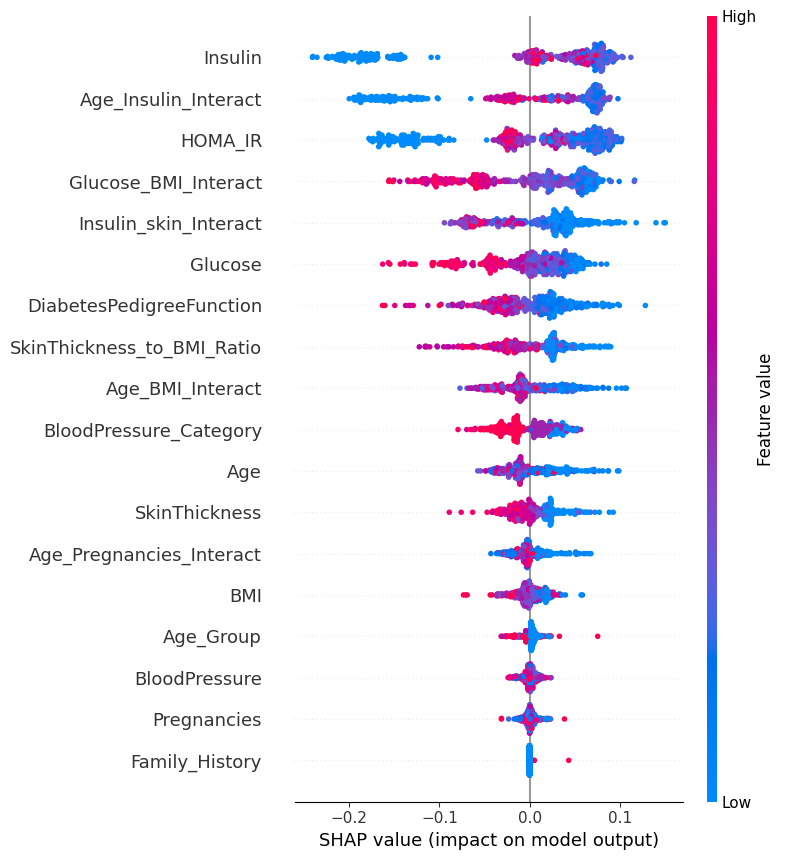

In [6]:
# Use SHAP to explain model predictions
explainer = shap.TreeExplainer(RandomFC)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values[:,:,0], X_train, feature_names=np.array(columns))

### PyTorch tensors


In [7]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


# Convert to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

### Deep Learning

In [8]:
def create_model(n1, n2,num_features):
    model = nn.Sequential(
        nn.Linear(num_features, n1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(n1, n2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(n2, 1),
        nn.Sigmoid()
    )
    return model

### CUDA

In [9]:
param = {'batch_size': 64, 'lr': 0.01, 'n1': 64, 'n2': 32, 'num_ep': 100}#{'batch_size': 64, 'lr': 0.01, 'n1': 32, 'n2': 32, 'num_ep': 150} #{'batch_size': 16, 'lr': 0.01, 'n1': 32, 'n2': 32, 'num_ep': 100}
model = create_model(param["n1"], param['n2'],num_features = 18)
# Define loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

## Training

In [29]:

import random
import numpy as np
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

param = {'batch_size': 16, 'lr': 0.001, 'n1': 16, 'n2': 64}#{'batch_size': 16, 'lr': 0.01, 'n1': 16, 'n2': 64}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 100
batch_size = param["batch_size"]

model = create_model(param["n1"], param['n2'], 18).to(device)
model.to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
train_precisions, val_precisions, test_precisions = [], [], []
train_recalls, val_recalls, test_recalls = [], [], []
train_f1_scores, val_f1_scores, test_f1_scores = [], [], []

best_val_acc, early_stop_counter, patience = 0, 0, 50

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i + batch_size]
        ybatch = y_train[i:i + batch_size]

        # Forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Compute training accuracy, precision, recall, and F1 score
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_accuracy = (y_pred_train.round() == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_precisions.append(train_precision)

        train_recall = recall_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_recalls.append(train_recall)

        train_f1 = f1_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_f1_scores.append(train_f1)

        # Compute validation loss, accuracy, precision, recall, and F1 score
        y_pred_val = model(X_val)
        val_loss = loss_fn(y_pred_val, y_val)
        val_losses.append(val_loss.item())
        val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_precisions.append(val_precision)

        val_recall = recall_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_recalls.append(val_recall)

        val_f1 = f1_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_f1_scores.append(val_f1)

        # Compute test loss, accuracy, precision, recall, and F1 score
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = (y_pred_test.round() == y_test).float().mean().item()
        test_accuracies.append(test_accuracy)

        test_precision = precision_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_precisions.append(test_precision)

        test_recall = recall_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_recalls.append(test_recall)

        test_f1 = f1_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_f1_scores.append(test_f1)

        # Check for early stopping
        if best_test_acc < test_accuracy:
            best_test_acc = test_accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} as test accuracy has not improved for {patience} epochs.')
            break

    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    if early_stop_counter >= patience:
        break


Epoch [1/100], Train Loss: 0.6595, Val Loss: 0.6524, Test Loss: 0.6477, Train Accuracy: 0.6774, Val Accuracy: 0.6827, Test Accuracy: 0.6786
Epoch [2/100], Train Loss: 0.5712, Val Loss: 0.5959, Test Loss: 0.5830, Train Accuracy: 0.7137, Val Accuracy: 0.7468, Test Accuracy: 0.7602
Epoch [3/100], Train Loss: 0.5913, Val Loss: 0.5270, Test Loss: 0.5034, Train Accuracy: 0.7372, Val Accuracy: 0.7692, Test Accuracy: 0.7806
Epoch [4/100], Train Loss: 0.5288, Val Loss: 0.4758, Test Loss: 0.4493, Train Accuracy: 0.7671, Val Accuracy: 0.7788, Test Accuracy: 0.8265
Epoch [5/100], Train Loss: 0.5074, Val Loss: 0.4408, Test Loss: 0.4119, Train Accuracy: 0.7821, Val Accuracy: 0.7981, Test Accuracy: 0.8316
Epoch [6/100], Train Loss: 0.3998, Val Loss: 0.4105, Test Loss: 0.3846, Train Accuracy: 0.8141, Val Accuracy: 0.8237, Test Accuracy: 0.8469
Epoch [7/100], Train Loss: 0.3278, Val Loss: 0.3858, Test Loss: 0.3630, Train Accuracy: 0.8205, Val Accuracy: 0.8333, Test Accuracy: 0.8571
Epoch [8/100], Train

## Model Performance Evaluation

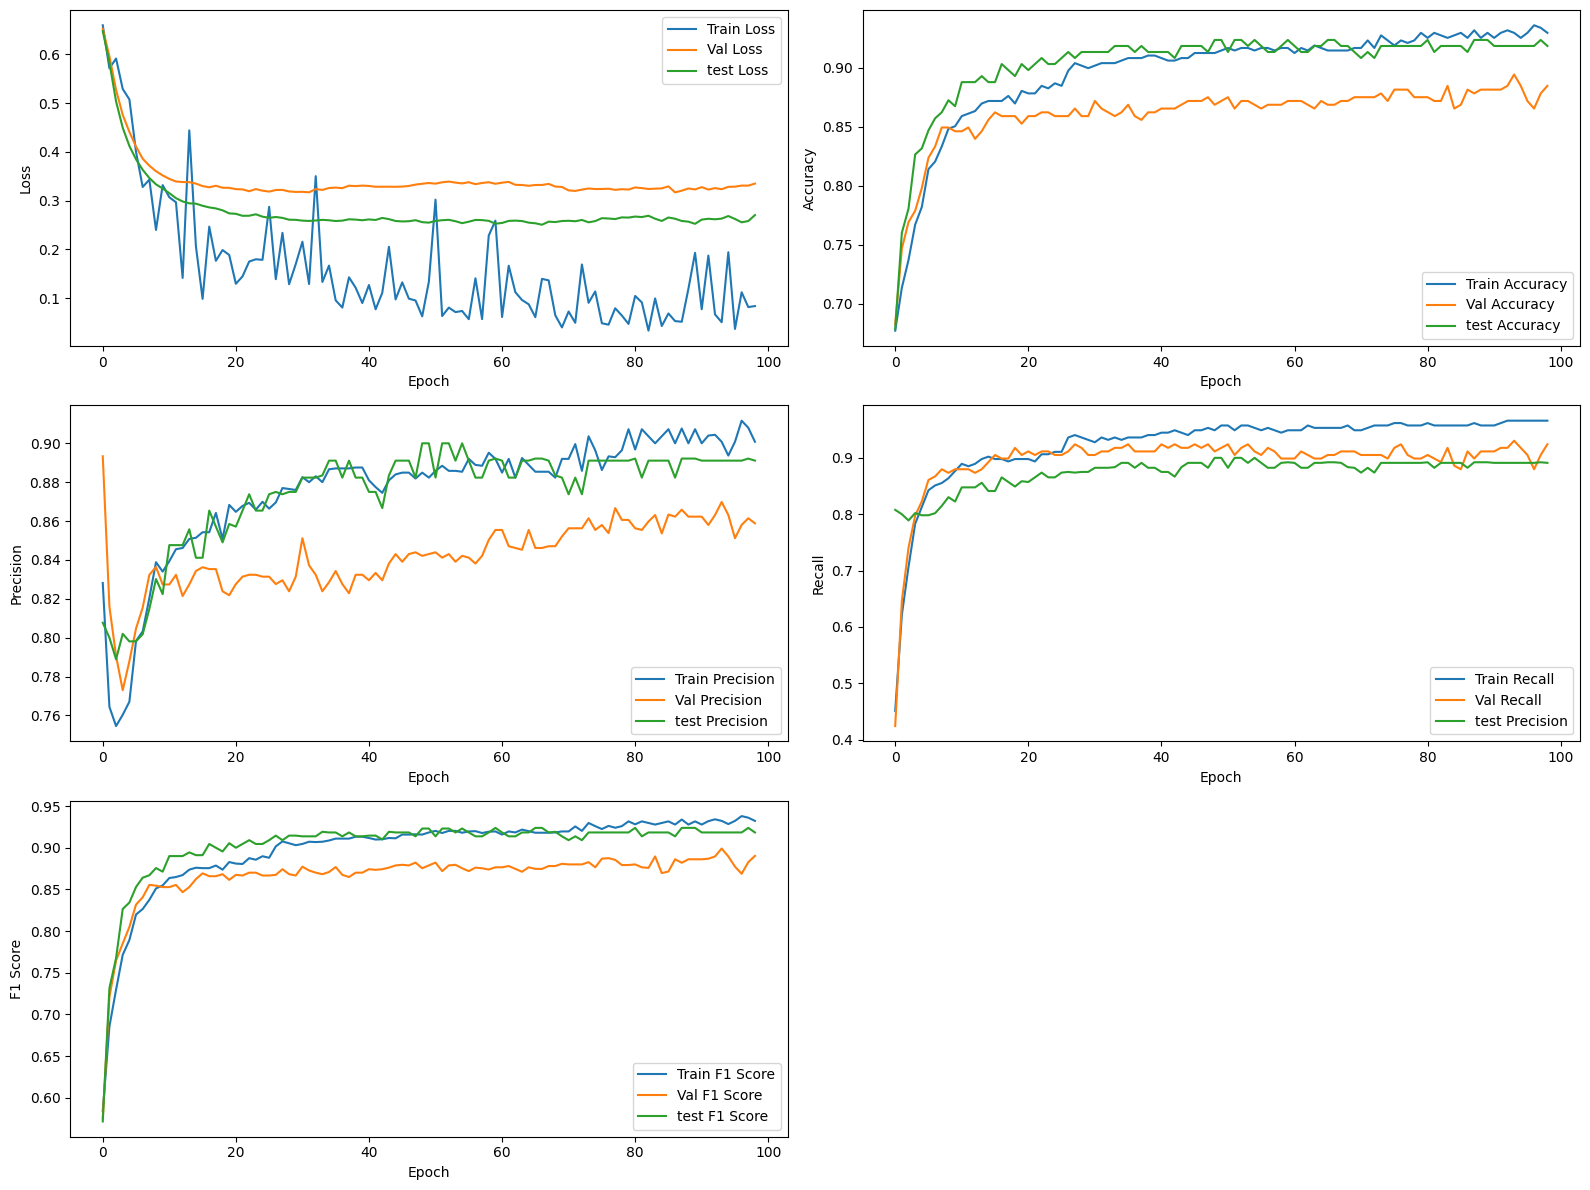

In [31]:
# validation metrics visualisation

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.plot(test_f1_scores, label='test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

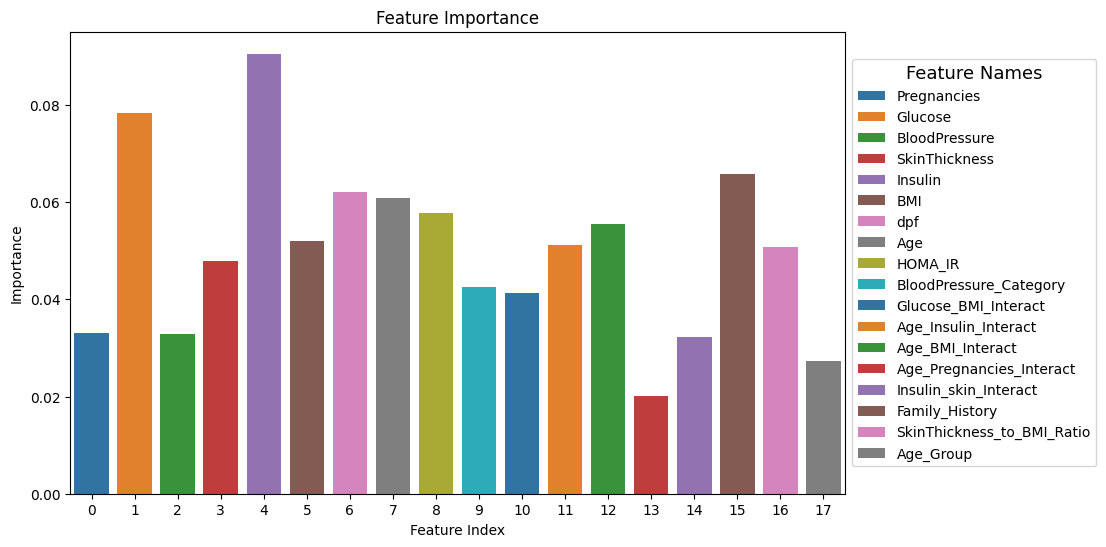

In [12]:

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'HOMA_IR',
       'BloodPressure_Category', 'Glucose_BMI_Interact',
       'Age_Insulin_Interact', 'Age_BMI_Interact', 'Age_Pregnancies_Interact',
       'Insulin_skin_Interact', 'Family_History', 'SkinThickness_to_BMI_Ratio',
       'Age_Group']
data = pd.DataFrame(df,columns=columns)
feature_names = data.columns.drop("Outcome").map(lambda x: "dpf" if x == "DiabetesPedigreeFunction" else x)



# Calculate feature importance
feature_importance = calculate_feature_importance(model, X_train)

# Plot the feature importance with labels
# Assuming 'feature_names' is a list containing the names of the features
colors = sns.color_palette(n_colors=len(feature_importance))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=np.arange(len(feature_importance)), y=feature_importance, palette=colors, hue=feature_names)

# Remove the legend from the plot
ax.legend_.remove()

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Create a legend outside the plot area
plt.legend(title="Feature Names", title_fontsize='13', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




In [13]:
importance_dict = {'importance':feature_importance,'feature':feature_names}

In [14]:
# Create a dictionary where keys are feature names and values are importance scores
feature_importance_dict = dict(zip(importance_dict['feature'], importance_dict['importance']))

# Sort the dictionary by importance scores in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select the top features with the highest importance scores
top_features = sorted_features[:10] 

# Print the top features
print("Top features with highest importance:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")


Top features with highest importance:
Insulin: 0.09055937081575394
Glucose: 0.07832866907119751
Family_History: 0.06589226424694061
dpf: 0.061999790370464325
Age: 0.060959190130233765
HOMA_IR: 0.05768435075879097
Age_BMI_Interact: 0.05542730912566185
BMI: 0.051989566534757614
Age_Insulin_Interact: 0.051270294934511185
SkinThickness_to_BMI_Ratio: 0.05083651840686798


In [15]:
best_features = []
for feature, importance in top_features:
    best_features.append(feature)
print(best_features)

['Insulin', 'Glucose', 'Family_History', 'dpf', 'Age', 'HOMA_IR', 'Age_BMI_Interact', 'BMI', 'Age_Insulin_Interact', 'SkinThickness_to_BMI_Ratio']


In [16]:
best_features = ['Age', 'BloodPressure_Category', 'dpf', 'Insulin', 'Glucose', 'Insulin_skin_Interact', 'BMI', 'Family_History', 'HOMA_IR', 'BloodPressure']
best_features.remove("dpf")
best_features.append("DiabetesPedigreeFunction")

In [17]:
X = data[best_features].values
y = data["Outcome"].values

In [18]:

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

param = {'batch_size': 32, 'lr': 0.01, 'n1': 64, 'n2': 32, 'num_ep': 100}

n_epochs = param["num_ep"]
batch_size = param["batch_size"]

model = create_model(param["n1"], param['n2'],18)
model.to(device)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_precisions = []
val_precisions = []
test_precisions = []
train_recalls = []
val_recalls = []
test_recalls = []
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []

best_test_acc = 0
early_stop_counter = 0
patience = 30  # Number of epochs to wait before early stopping if validation accuracy doesn't improve

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i + batch_size]
        ybatch = y_train[i:i + batch_size]

        # Forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Compute training accuracy, precision, recall, and F1 score
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_accuracy = (y_pred_train.round() == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_precisions.append(train_precision)

        train_recall = recall_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_recalls.append(train_recall)

        train_f1 = f1_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_f1_scores.append(train_f1)

        # Compute validation loss, accuracy, precision, recall, and F1 score
        y_pred_val = model(X_val)
        val_loss = loss_fn(y_pred_val, y_val)
        val_losses.append(val_loss.item())
        val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_precisions.append(val_precision)

        val_recall = recall_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_recalls.append(val_recall)

        val_f1 = f1_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_f1_scores.append(val_f1)

        # Compute test loss, accuracy, precision, recall, and F1 score
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = (y_pred_test.round() == y_test).float().mean().item()
        test_accuracies.append(test_accuracy)

        test_precision = precision_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_precisions.append(test_precision)

        test_recall = recall_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_recalls.append(test_recall)

        test_f1 = f1_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_f1_scores.append(test_f1)

        # Check for early stopping
        if best_test_acc < test_accuracy:
            best_test_acc = test_accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} as test accuracy has not improved for {patience} epochs.')
            break

    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    if early_stop_counter >= patience:
        break


Epoch [1/100], Train Loss: 0.5469, Val Loss: 0.4443, Test Loss: 0.4059, Train Accuracy: 0.7927, Val Accuracy: 0.7756, Test Accuracy: 0.8316
Epoch [2/100], Train Loss: 0.2702, Val Loss: 0.3824, Test Loss: 0.3472, Train Accuracy: 0.8526, Val Accuracy: 0.8269, Test Accuracy: 0.8673
Epoch [3/100], Train Loss: 0.2389, Val Loss: 0.3458, Test Loss: 0.2905, Train Accuracy: 0.8761, Val Accuracy: 0.8494, Test Accuracy: 0.8980
Epoch [4/100], Train Loss: 0.1784, Val Loss: 0.3459, Test Loss: 0.2731, Train Accuracy: 0.8761, Val Accuracy: 0.8526, Test Accuracy: 0.9031
Epoch [5/100], Train Loss: 0.2316, Val Loss: 0.3344, Test Loss: 0.2726, Train Accuracy: 0.9017, Val Accuracy: 0.8622, Test Accuracy: 0.9031
Epoch [6/100], Train Loss: 0.2088, Val Loss: 0.3424, Test Loss: 0.2704, Train Accuracy: 0.9167, Val Accuracy: 0.8718, Test Accuracy: 0.9133
Epoch [7/100], Train Loss: 0.1931, Val Loss: 0.3652, Test Loss: 0.2935, Train Accuracy: 0.9103, Val Accuracy: 0.8622, Test Accuracy: 0.9184
Epoch [8/100], Train

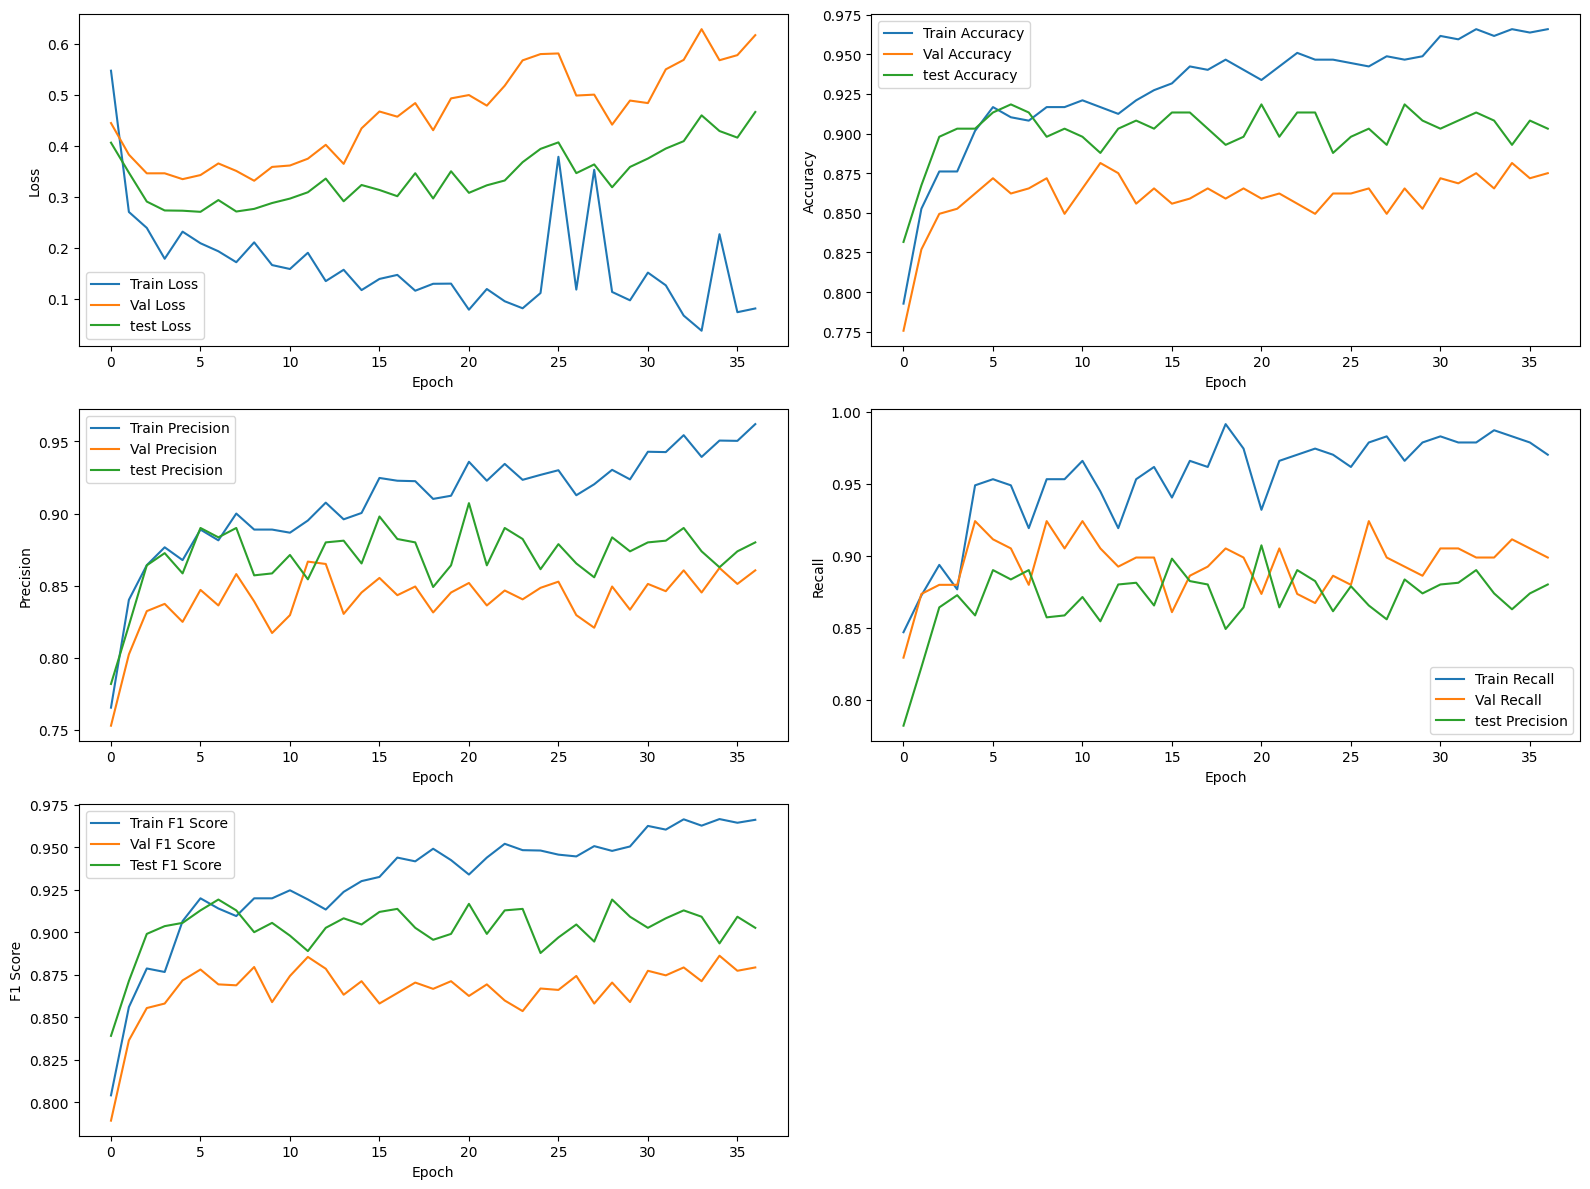

In [19]:
# validation metrics visualisation

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.plot(test_f1_scores, label='Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## Hyper Parameter Tuning

cosine anealing learning rate

In [20]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define the grid search parameters
grid_params = {
    'batch_size': [8,16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'n1': [16, 32, 64],
    'n2': [32, 64, 128]
}

best_params = None
best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop through all combinations of hyperparameters
for params in product(*grid_params.values()):
    param = dict(zip(grid_params.keys(), params))
    model = create_model(param["n1"], param['n2'],18)
    model.to(device)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=param['lr'])
    n_epochs = 100
    batch_size = param["batch_size"]

    train_losses = []
    val_losses = []

    best_epoch = 0
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 20  # Number of epochs to wait before early stopping if validation loss doesn't improve

    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i + batch_size]
            ybatch = y_train[i:i + batch_size]

            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = loss_fn(y_pred_val, y_val)
            val_losses.append(val_loss.item())
            y_pred_val = model(X_val)
            val_accuracy = (y_pred_val.round() == y_val).float().mean().item()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch + 1} for parameter combination: {param}')
            break

    print(f'\nParameters: {param}, Best Validation Loss: {best_val_loss:.4f}, Val_acc:{val_accuracy} at epoch {best_epoch + 1}')

    if best_params is None or best_val_loss < best_params['best_val_loss']:
        best_params = {'param': param, 'best_val_loss': best_val_loss}

print("\nBest Parameters:", best_params)



Early stopping at epoch 37 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}, Best Validation Loss: 0.3113, Val_acc:0.8525640964508057 at epoch 17

Early stopping at epoch 55 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}, Best Validation Loss: 0.3129, Val_acc:0.875 at epoch 35

Early stopping at epoch 45 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}, Best Validation Loss: 0.3048, Val_acc:0.8621795177459717 at epoch 25

Early stopping at epoch 46 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 32, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 32, 'n2': 32}, Best Validation Loss: 0.3181, Val_acc:0.8717948794364929 at epoch 26

Early stopping at epoch 37 for parameter combinati

**observations**


Given the small dataset size, it's essential to be cautious about overfitting, as the model might simply be memorizing the training examples rather than learning generalizable patterns. The high validation accuracy of 83.42% is encouraging, indicating that the model performs reasonably well on unseen data, but the significant gap between training and validation accuracies (nearly 13 percentage points) suggests overfitting.